## Learning the meso-scale dynamics

This notebook aims to demonstrate the learning process and prediction for the *meso-scale* time evolution of the coupled physical fields $(T, P, \mu)$ involved in shock-induced energy localization in porous energetic material. The meso-scale dynamics model is based on top of the pre-learned probabilistic latent representation of the *micro-scale* evolution of the physical fields. The meso-scale model `MesoDynamicsCoupledEfficient` learns the correlation between micro-scale neighboring building blocks whose dynamics is learned by the micro-scale model `MicroDynamicsCoupledEfficient`. 

The notebook primarily covers three sections:
- preparing the meso-scale data in appropriate format
- training the meso-scale model 
- predicted evolution of the physical fields and corresponding latent fields over the latent space

In [ ]:
import numpy as np
import tensorflow as tf
import os
import sys
import pickle 
import matplotlib.pyplot as plt

2025-02-19 11:43:35.337456: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Loading pre-processed data

The meso-scale simulation data consist of snapshots from time evolution of temperature $T$, pressure $P$ and microstructural morphology $\mu$ fields over a meso-scale shock-loaded domain of porous energetic material. The values of each physical field is normalized to the interval $ [0,1] $. The spatial size, i.e. input-height and input-width, of the snapshots is cropped to a multiple of $ 2^5 $ to be compatible with the architecture of the VAE and the latent dynamics autoregressive functionals. The temporal snapshots of physical fields are concatenated into a Numpy array `evolving_3fields_traj.npy` of shape (samples, input-height, input-width, physical fields, time-steps).

In addition, the corresponding VAE-encoded latent mean fields $\bar{Z}$ and latent log-variance fields $Z^\sigma$ are concatenated into Numpy arrays `encoded_latent_mean_fields_traj.npy` and `encoded_latent_var_fields_traj.npy`, respectively, of the shape (samples, latent-height, latent-width, latent fields, time-steps).

In [ ]:
base_dir = '/home/user/Multiscale-Latent-Dynamics' # replace with your path
data_dir = os.path.join( base_dir, 'processed_data/meso_scale' ) 

In [ ]:
state_traj = np.load(os.path.join(data_dir, 'evolving_3fields_traj.npy'))
state_traj.shape

(26, 320, 480, 3, 38)

In [ ]:
latent_mean_traj = np.load( os.path.join( data_dir, "encoded_latent_mean_fields_traj.npy" ) )
latent_var_traj = np.load( os.path.join( data_dir, "encoded_latent_var_fields_traj.npy" ) )
print((latent_mean_traj.shape, latent_var_traj.shape))

((26, 40, 60, 12, 38), (26, 40, 60, 12, 38))


### Training the meso-scale latent dynamics model `MesoDynamicsCoupledEfficient`

In order to improve the memory efficiency of the training process, the original physical fields are first encoded into the latent space. The meso-scale model learns the induced trajectory over the latent space, and the corresponding reconstructed trajectory into the input space is compared with the ground truth.

Training the meso-scale model follows a *curriculum learning* strategy in which the predicted time-horizon $ts$ increase successively. To this end, the full trajectory of the VAE-encoded latent fields $(\bar{Z}, Z^\sigma)$ and physical fields $(T, P, \mu)$ is formatted into a `tf.dataset` of pairs of the form (input, output) in which:
- input = temporal snapshot of latent fields $(\bar{Z}, Z^\sigma)$ at time $t_i$
- output = temporal snapshots of latent fields $(\bar{Z}, Z^\sigma)$ and physical fields $(T, P, \mu)$ corresponding to the next $ts$ time-steps, i.e. $t \in \{ t_{i+1}, \cdots , t_{i+ ts} \}$


In [ ]:
# local modules
module_dir = os.path.join( base_dir, 'Multiscale-Latent-Dynamics' ) 
sys.path.append(module_dir)
from models.meso_dynamics_coupled_efficient import MesoDynamicsCoupledEfficient
from utils.train_utils import in_out_latent_dataset, CheckPoint
from utils.dir_hyper import dyn_dir, mkdir_ifnot
from utils.visualization import plot_pred_field

In [ ]:
n_epoch_list = [2, 2] # number of epochs
lr_list = [1e-4, 1e-4]  # learning rates 
bs = 1 # batch size
field_idx = 0
fields = ['temperature', 'pressure', 'microstructure'] # list of physical fields
dynamics_model = 'unet' # architecture of latent dynamics autoregressive functionals
dir = f"{dyn_dir(dynamics_model)['meso_dyn']['coupled']}" # directory for loading and saving the weights of meso-scale autoregressive functionals


for ts_idx in range(0, 2):  # `ts_idx` specifies the length of predicted time-horizon

    # prepare batched tf.dataset for curriculum training
    train_data = in_out_latent_dataset(latent_mean_traj, latent_var_traj, state_traj,
                                       sample_range=[0, 18], n_ts=ts_idx+1, batch_size=bs)

    val_data = in_out_latent_dataset(latent_mean_traj, latent_var_traj, state_traj,
                                       sample_range=[18, 20], n_ts=ts_idx+1, batch_size=bs)

    # initialize the meso-scale model
    tf.keras.backend.clear_session()
    meso_dynamics_coupled_efficient = MesoDynamicsCoupledEfficient(meso_ts=ts_idx + 1,
                                                                meso_micro_ts_ratio=2,
                                                                fields = fields,
                                                                output_fields=[(field_idx, fields[field_idx])],
                                                                latent_shape=(40, 60, 4),
                                                                loss_weights=[1, 1, 1],
                                                                dynamics_model=dynamics_model)

    # call model on a sample to create the model's variables before being able to load the weights
    init_z_mean = latent_mean_traj[0:1, :,:,:, 0:1]
    init_z_var = latent_var_traj[0:1, :,:,:, 0:1]
    output_fields = [(field_idx, fields[field_idx])]
    input = [init_z_mean, init_z_var, 1, output_fields]
    meso_dynamics_coupled_efficient.call(input)

    # load weights corresponding to the decoupled evolution of fields at micro-scale
    meso_dynamics_coupled_efficient.load_micro_decoupled_evol(pretrain_ts=[0, 0, 0], n_epochs=[0, 0, 0])

    if ts_idx > 0:  # load weights corresponding to the previous temporal sequence at meso-scale
        prev_weight_dir = os.path.join(dir, f"ts_{ts_idx}")
        meso_dynamics_coupled_efficient.load_weight(ts=ts_idx, n_epochs=n_epoch_list[ts_idx-1], weight_dir=prev_weight_dir)

    elif ts_idx == 0:  # load weights corresponding to the coupled evolution of fields at micro-scale
        meso_dynamics_coupled_efficient.load_weight(ts=0, n_epochs=0, weight_dir=os.path.join(dir, 'pretrain'))

    # build and train the model 
    meso_dynamics_coupled_efficient.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_list[ts_idx], beta_1=0.5, beta_2=0.99))
    current_weight_dir = os.path.join(dir, f"ts_{ts_idx+1}")
    mkdir_ifnot(current_weight_dir)
    callback = CheckPoint(current_weight_dir, ckpt_period=1, spatial_scale='meso')                       
    history = meso_dynamics_coupled_efficient.fit(train_data, epochs=n_epoch_list[ts_idx], callbacks=[callback], validation_data=val_data)
    meso_dynamics_coupled_efficient.save_weight(ts_idx+1, n_epoch_list[ts_idx], current_weight_dir)
    with open(os.path.join(current_weight_dir, f'loss_history_{ts_idx+1}_ts.pkl'), 'wb') as file:
        pickle.dump(history.history, file)


2025-02-19 11:43:58.227917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46581 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-02-19 11:44:02.898859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2025-02-19 11:44:03.426504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1/2


2025-02-19 11:44:43.180960: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5607181b3840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-19 11:44:43.181007: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-02-19 11:44:43.268300: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-19 11:44:43.951372: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


74/74 [==============================] - 53s 209ms/step - total_loss: 1.0352 - consistency_mean_loss: 0.6406 - consistency_var_loss: 0.3809 - multi_step_loss: 0.0138 - val_total_loss: 0.7897 - val_consistency_mean_loss: 0.5781 - val_consistency_var_loss: 0.2035 - val_multi_step_loss: 0.0082
Epoch 2/2
74/74 [==============================] - 11s 145ms/step - total_loss: 0.7399 - consistency_mean_loss: 0.5374 - consistency_var_loss: 0.1957 - multi_step_loss: 0.0067 - val_total_loss: 0.6600 - val_consistency_mean_loss: 0.5176 - val_consistency_var_loss: 0.1367 - val_multi_step_loss: 0.0057
Epoch 1/2
72/72 [==============================] - 74s 370ms/step - total_loss: 1.8387 - consistency_mean_loss: 1.2346 - consistency_var_loss: 0.5877 - multi_step_loss: 0.0164 - val_total_loss: 2.1726 - val_consistency_mean_loss: 1.4446 - val_consistency_var_loss: 0.7087 - val_multi_step_loss: 0.0193
Epoch 2/2
72/72 [==============================] - 19s 260ms/step - total_loss: 1.7805 - consistency_mea

### MesoDynamicsCoupledEfficient Prediction

In [7]:
ns = 10 # number of samples used for training of the model
ts_idx = 4
n_epochs = 50
field_idx = 0
fields = ['temperature', 'pressure', 'microstructure']
dynamics_model = 'unet'

#
# dir = f"{dyn_dir(dynamics_model)['micro_dyn']['coupled']}"
# weight_dir = os.path.join(dir, "weights_0_ts")

dir = f"{dyn_dir(dynamics_model)['meso_dyn']['coupled']}"
weight_dir = os.path.join(dir, f"data_320_480/experiment/{ns}_sample_train/ts_{ts_idx+1}")

# dir = f"{dyn_dir(dynamics_model)['meso_dyn']['coupled']}"
# weight_dir = os.path.join(dir, "data_320_480/weights_5_ts_drop_1_weight_100")

meso_dynamics_coupled_efficient = MesoDynamicsCoupledEfficient(meso_ts=ts_idx + 1,
                                                                meso_micro_ts_ratio=2,
                                                                fields = fields,
                                                                output_fields=[(field_idx, fields[field_idx])],
                                                                latent_shape=(40, 60, 4),
                                                                loss_weights=[1, 1, 1],
                                                                dynamics_model=dynamics_model)
                                                
### call on a sample
init_z_mean = latent_mean_traj[0:1, :,:,:, 0:1]
init_z_var = latent_var_traj[0:1, :,:,:, 0:1]
output_fields = [(field_idx, fields[field_idx])]
input = [init_z_mean, init_z_var, 1, output_fields]
meso_dynamics_coupled_efficient.call(input)
###
meso_dynamics_coupled_efficient.load_micro_decoupled_evol(pretrain_ts=[0, 0, 0], n_epochs=[0, 0, 0])
meso_dynamics_coupled_efficient.load_weight(ts=ts_idx+1, n_epochs=n_epochs, weight_dir=weight_dir)
# latent_parc_coupled.load_weight(ts=0, n_epochs=0, weight_dir=weight_dir)
meso_dynamics_coupled_efficient.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5,beta_2=0.99))

In [8]:
sample = 24 # test samples 24, 25; validation samples 22, 23;
init_step = 0
meso_evol_step = 37
field_idx = 0
init_z_mean = latent_mean_traj[sample:sample+1, :,:,:, init_step:init_step+1]
init_z_var = latent_var_traj[sample:sample+1, :,:,:, init_step:init_step+1]
output_fields = [(field_idx, fields[field_idx])]
input = [init_z_mean, init_z_var, meso_evol_step, output_fields]
x_evol_traj, z_mean_traj, z_var_traj = meso_dynamics_coupled_efficient.call(input)
x_evol_traj, z_mean_traj, z_var_traj = x_evol_traj.numpy(), z_mean_traj.numpy(), z_var_traj.numpy()
print((x_evol_traj.shape, z_mean_traj.shape)) 

((1, 320, 480, 1, 38), (1, 40, 60, 12, 38))


In [9]:
field_gt = state_traj[sample:sample+1,:,:, field_idx:field_idx+1, init_step:init_step+meso_evol_step+1]
c0, c1 = (field_idx * meso_dynamics_coupled_efficient.latent_shape[2]), (( field_idx + 1) * meso_dynamics_coupled_efficient.latent_shape[2]) 
x = np.moveaxis(np.concatenate([field_gt[..., ::], x_evol_traj[..., ::]], axis=0), (0,1,2,3,4), (0,2,3,4,1))
z = np.moveaxis(np.concatenate([z_mean_traj[..., c0:c1, ::], z_var_traj[..., c0:c1, ::]], axis=0), (0,1,2,3,4), (0,2,3,4,1))

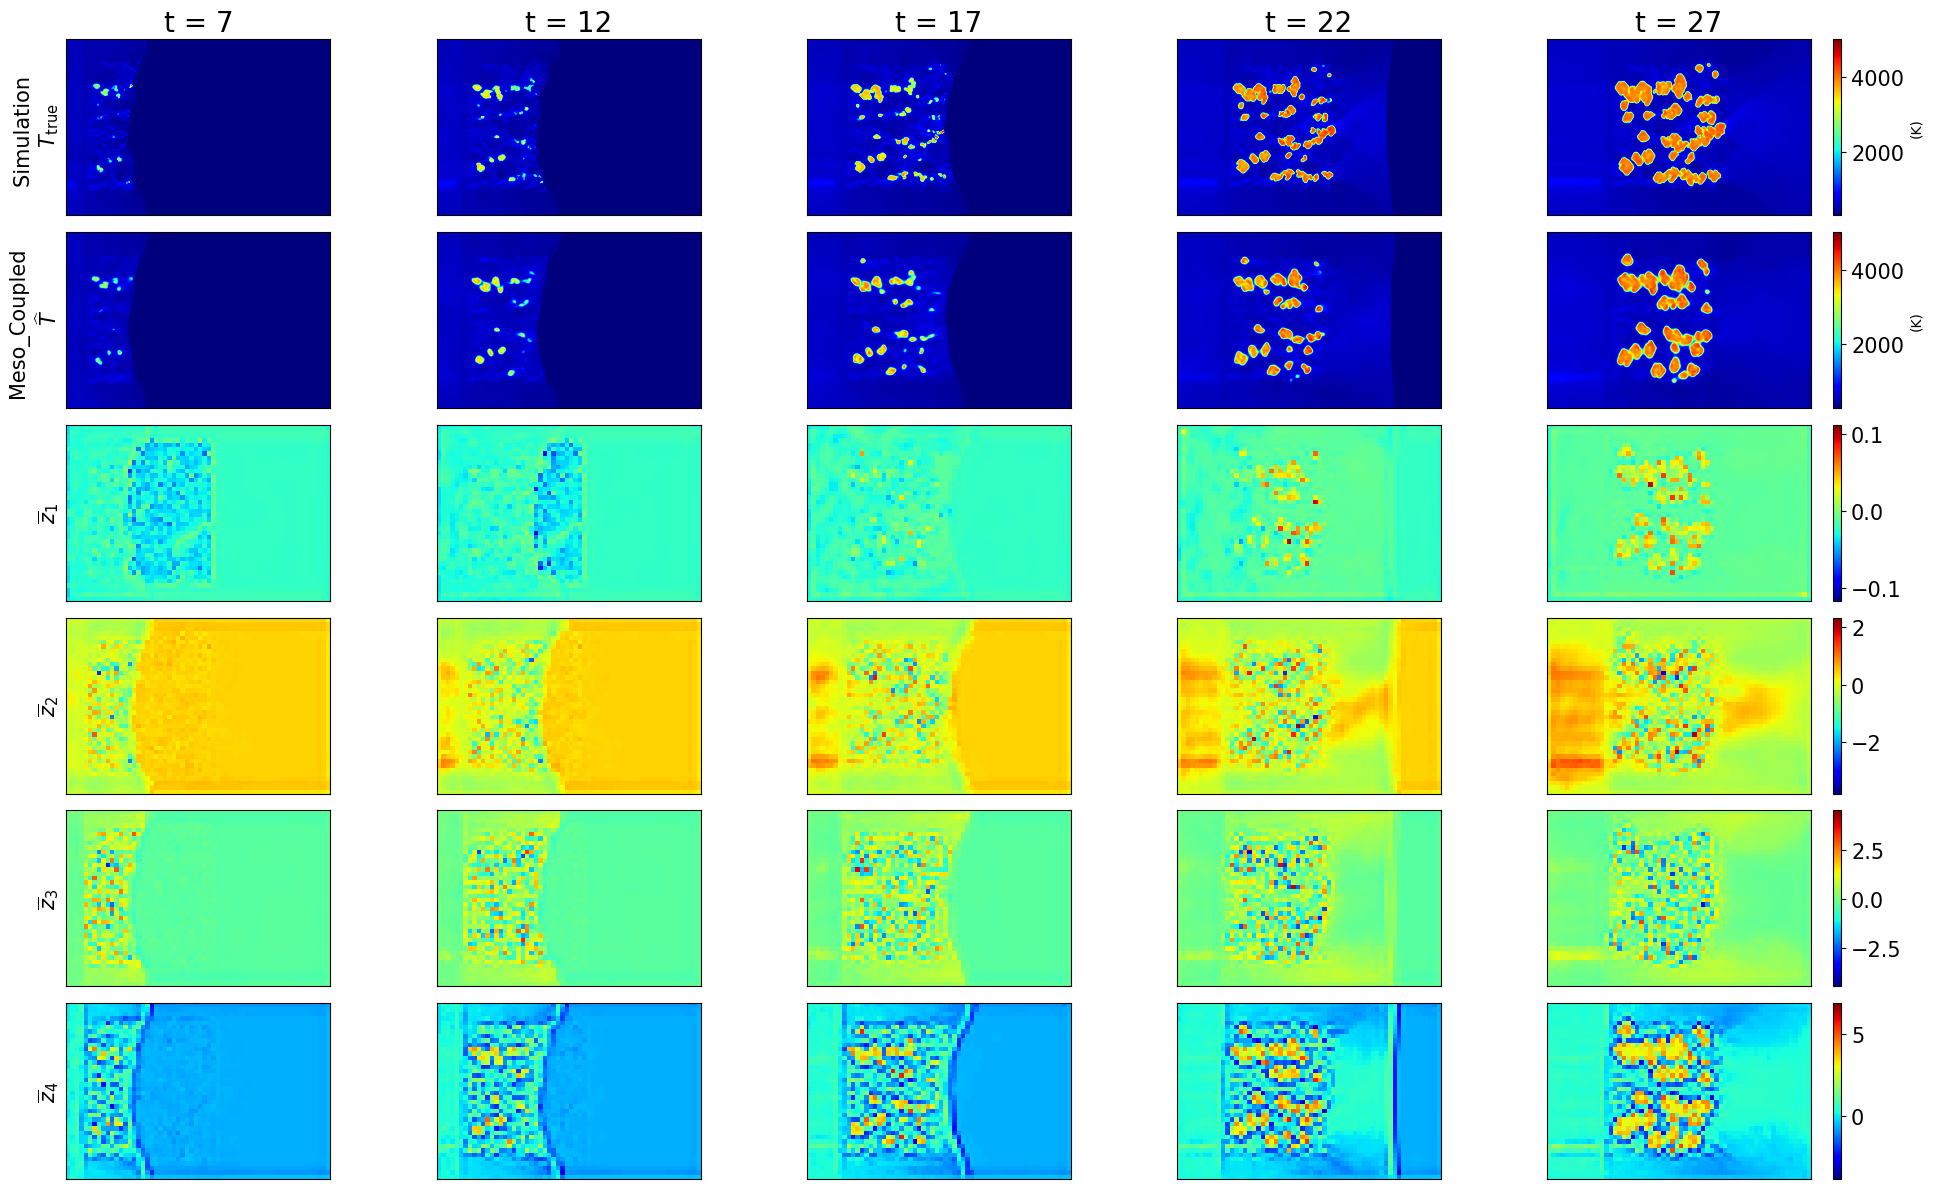

In [10]:
fig = plot_pred_field(x, z, t0=7, ts=5, field_idx=field_idx, spatial_scale='meso', mean_var='mean', n_rows=6)